In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
#device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda: 3" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda:3
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
class StateHolder:

    def __init__ (self):
        self.state = torch.zeros (4, 1, 84, 84)
    
    def push (self, screen):
        self.state [3] = self.state [2]
        self.state [2] = self.state [1]
        self.state [1] = self.state [0]
        self.state [0] = screen
        
    def get (self):
        return self.state.permute (1, 0, 2, 3)
    
    def reset (self):
        self.state = torch.zeros (4, 1, 84, 84)
    
        
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DQN(nn.Module):
    
    def __init__ (self):
        super(DQN, self).__init__()
        self.relu  = nn.ReLU        ()
        self.conv1 = nn.Conv2d      (4 , 32, kernel_size = 5, stride = 2)
        self.bn1   = nn.BatchNorm2d (32)
        self.conv2 = nn.Conv2d      (32, 64, kernel_size = 5, stride = 2)
        self.bn2   = nn.BatchNorm2d (64)
        self.conv3 = nn.Conv2d      (64, 64, kernel_size = 5, stride = 2)
        self.bn3   = nn.BatchNorm2d (64)
        self.fc    = nn.Linear      (56 * 56, 4)    #not sure about 512
        
    def forward  (self, x):
        x = self.conv1 (x)
        x = self.bn1   (x)
        x = self.relu  (x)
        
        x = self.conv2 (x)
        x = self.bn2   (x)
        x = self.relu  (x)
        
        x = self.conv3 (x)
        x = self.bn3   (x)
        x = self.relu  (x)
        
        x = x.view     (x.size(0), -1)
        x = self.fc    (x)
        
        return x
        
        
        

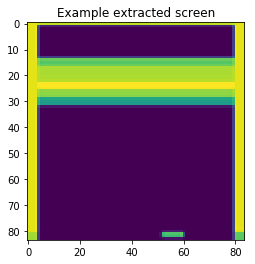

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

env.reset()
plt.figure()
#print (get_screen().size())
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

memory = ReplayMemory()
state_holder = StateHolder()

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на шаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach().to(device) # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

In [9]:
import pickle

def saveToFile (net, filename):
    with open (filename, "wb") as file:
        pickle.dump(net, file)
        
def loadFromFile (filename):
    with open (filename, "rb") as file:
        return pickle.load(file)


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode score : 0.0
Mean score : 1.309999942779541



  0%|          | 2/100000 [01:50<2143:36:47, 77.17s/it] 

Episode score : 1.0
Mean score : 1.2999999523162842



  0%|          | 3/100000 [01:51<1507:43:48, 54.28s/it]

Episode score : 2.0
Mean score : 1.2999999523162842



  0%|          | 4/100000 [01:52<1060:02:46, 38.16s/it]

Episode score : 0.0
Mean score : 1.2999999523162842



  0%|          | 5/100000 [01:52<747:42:03, 26.92s/it] 

Episode score : 0.0
Mean score : 1.2899999618530273



  0%|          | 6/100000 [01:53<529:20:05, 19.06s/it]

Episode score : 1.0
Mean score : 1.2899999618530273
Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 8/100000 [01:55<270:51:47,  9.75s/it]

Episode score : 2.0
Mean score : 1.2599999904632568



  0%|          | 9/100000 [01:55<196:10:11,  7.06s/it]

Episode score : 2.0
Mean score : 1.2799999713897705



  0%|          | 10/100000 [01:56<141:51:02,  5.11s/it]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 11/100000 [01:57<105:03:10,  3.78s/it]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 12/100000 [01:57<79:08:59,  2.85s/it] 

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 13/100000 [01:58<60:06:03,  2.16s/it]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 14/100000 [01:59<47:22:45,  1.71s/it]

Episode score : 1.0
Mean score : 1.25



  0%|          | 15/100000 [01:59<37:27:41,  1.35s/it]

Episode score : 0.0
Mean score : 1.2200000286102295



  0%|          | 16/100000 [02:00<32:49:08,  1.18s/it]

Episode score : 2.0
Mean score : 1.2300000190734863



  0%|          | 17/100000 [02:01<31:17:28,  1.13s/it]

Episode score : 2.0
Mean score : 1.2300000190734863



  0%|          | 18/100000 [02:01<27:11:59,  1.02it/s]

Episode score : 1.0
Mean score : 1.2000000476837158



  0%|          | 19/100000 [02:02<26:04:04,  1.07it/s]

Episode score : 2.0
Mean score : 1.190000057220459



  0%|          | 20/100000 [02:03<23:05:48,  1.20it/s]

Episode score : 0.0
Mean score : 1.1699999570846558



  0%|          | 21/100000 [02:04<27:12:37,  1.02it/s]

Episode score : 4.0
Mean score : 1.2100000381469727



  0%|          | 22/100000 [02:05<25:16:56,  1.10it/s]

Episode score : 1.0
Mean score : 1.2200000286102295



  0%|          | 23/100000 [02:06<24:36:02,  1.13it/s]

Episode score : 2.0
Mean score : 1.2400000095367432



  0%|          | 24/100000 [02:06<21:35:26,  1.29it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 25/100000 [02:07<22:36:02,  1.23it/s]

Episode score : 2.0
Mean score : 1.25



  0%|          | 26/100000 [02:08<22:50:22,  1.22it/s]

Episode score : 2.0
Mean score : 1.2400000095367432
Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 28/100000 [02:10<21:19:55,  1.30it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 29/100000 [02:10<21:02:34,  1.32it/s]

Episode score : 1.0
Mean score : 1.2300000190734863



  0%|          | 30/100000 [02:11<21:01:28,  1.32it/s]

Episode score : 1.0
Mean score : 1.2200000286102295



  0%|          | 31/100000 [02:12<19:25:29,  1.43it/s]

Episode score : 0.0
Mean score : 1.2100000381469727



  0%|          | 32/100000 [02:12<20:07:49,  1.38it/s]

Episode score : 1.0
Mean score : 1.2100000381469727



  0%|          | 33/100000 [02:13<19:20:37,  1.44it/s]

Episode score : 1.0
Mean score : 1.2200000286102295



  0%|          | 34/100000 [02:14<20:53:05,  1.33it/s]

Episode score : 2.0
Mean score : 1.2300000190734863



  0%|          | 35/100000 [02:15<20:39:00,  1.34it/s]

Episode score : 1.0
Mean score : 1.2200000286102295



  0%|          | 36/100000 [02:16<23:50:31,  1.16it/s]

Episode score : 4.0
Mean score : 1.2599999904632568



  0%|          | 37/100000 [02:16<22:16:08,  1.25it/s]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 38/100000 [02:17<20:20:21,  1.37it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 39/100000 [02:18<19:45:45,  1.41it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 40/100000 [02:19<21:25:05,  1.30it/s]

Episode score : 2.0
Mean score : 1.2400000095367432



  0%|          | 41/100000 [02:19<19:27:39,  1.43it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 42/100000 [02:20<18:30:58,  1.50it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 43/100000 [02:20<17:31:56,  1.58it/s]

Episode score : 0.0
Mean score : 1.2300000190734863
Target net updated!



  0%|          | 44/100000 [02:21<19:00:10,  1.46it/s]

Episode score : 2.0
Mean score : 1.25



  0%|          | 45/100000 [02:22<20:46:08,  1.34it/s]

Episode score : 2.0
Mean score : 1.2599999904632568



  0%|          | 46/100000 [02:23<19:34:02,  1.42it/s]

Episode score : 0.0
Mean score : 1.2599999904632568
Episode score : 1.0
Mean score : 1.2599999904632568



  0%|          | 48/100000 [02:24<21:42:54,  1.28it/s]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 49/100000 [02:25<23:39:59,  1.17it/s]

Episode score : 3.0
Mean score : 1.2899999618530273



  0%|          | 50/100000 [02:26<26:37:43,  1.04it/s]

Episode score : 5.0
Mean score : 1.340000033378601



  0%|          | 51/100000 [02:27<23:23:39,  1.19it/s]

Episode score : 0.0
Mean score : 1.340000033378601



  0%|          | 52/100000 [02:28<20:51:18,  1.33it/s]

Episode score : 0.0
Mean score : 1.3300000429153442



  0%|          | 53/100000 [02:29<23:19:44,  1.19it/s]

Episode score : 4.0
Mean score : 1.350000023841858



  0%|          | 54/100000 [02:29<23:29:27,  1.18it/s]

Episode score : 2.0
Mean score : 1.3700000047683716



  0%|          | 55/100000 [02:30<23:45:43,  1.17it/s]

Episode score : 2.0
Mean score : 1.350000023841858



  0%|          | 56/100000 [02:31<22:53:52,  1.21it/s]

Episode score : 1.0
Mean score : 1.340000033378601



  0%|          | 57/100000 [02:32<20:38:31,  1.34it/s]

Episode score : 0.0
Mean score : 1.309999942779541



  0%|          | 58/100000 [02:32<19:08:36,  1.45it/s]

Episode score : 0.0
Mean score : 1.2799999713897705



  0%|          | 59/100000 [02:33<18:08:31,  1.53it/s]

Episode score : 0.0
Mean score : 1.2599999904632568



  0%|          | 60/100000 [02:33<17:05:20,  1.62it/s]

Episode score : 0.0
Mean score : 1.2400000095367432



  0%|          | 61/100000 [02:34<21:23:43,  1.30it/s]

Episode score : 3.0
Mean score : 1.2400000095367432



  0%|          | 62/100000 [02:35<19:33:33,  1.42it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 63/100000 [02:36<20:46:41,  1.34it/s]

Episode score : 2.0
Mean score : 1.2300000190734863



  0%|          | 64/100000 [02:36<19:50:09,  1.40it/s]

Episode score : 0.0
Mean score : 1.2200000286102295



  0%|          | 65/100000 [02:37<21:14:32,  1.31it/s]

Episode score : 2.0
Mean score : 1.2200000286102295
Episode score : 2.0
Mean score : 1.2200000286102295



  0%|          | 67/100000 [02:39<22:02:33,  1.26it/s]

Episode score : 1.0
Mean score : 1.2300000190734863



  0%|          | 68/100000 [02:40<21:03:56,  1.32it/s]

Episode score : 1.0
Mean score : 1.2100000381469727



  0%|          | 69/100000 [02:40<20:56:28,  1.33it/s]

Episode score : 0.0
Mean score : 1.2100000381469727



  0%|          | 70/100000 [02:41<19:27:30,  1.43it/s]

Episode score : 0.0
Mean score : 1.1699999570846558



  0%|          | 71/100000 [02:42<18:18:21,  1.52it/s]

Episode score : 0.0
Mean score : 1.1699999570846558



  0%|          | 72/100000 [02:42<17:30:23,  1.59it/s]

Episode score : 0.0
Mean score : 1.1699999570846558



  0%|          | 73/100000 [02:43<20:21:59,  1.36it/s]

Episode score : 3.0
Mean score : 1.1799999475479126



  0%|          | 74/100000 [02:44<19:04:49,  1.45it/s]

Episode score : 0.0
Mean score : 1.1200000047683716



  0%|          | 75/100000 [02:44<17:46:14,  1.56it/s]

Episode score : 0.0
Mean score : 1.1200000047683716



  0%|          | 76/100000 [02:45<19:00:55,  1.46it/s]

Episode score : 2.0
Mean score : 1.1299999952316284



  0%|          | 77/100000 [02:46<18:56:06,  1.47it/s]

Episode score : 1.0
Mean score : 1.1200000047683716



  0%|          | 78/100000 [02:46<17:31:09,  1.58it/s]

Episode score : 0.0
Mean score : 1.1100000143051147



  0%|          | 79/100000 [02:47<19:09:59,  1.45it/s]

Episode score : 2.0
Mean score : 1.1100000143051147



  0%|          | 80/100000 [02:48<20:01:00,  1.39it/s]

Episode score : 2.0
Mean score : 1.1299999952316284



  0%|          | 81/100000 [02:49<23:19:37,  1.19it/s]

Episode score : 4.0
Mean score : 1.1699999570846558



  0%|          | 82/100000 [02:50<21:37:06,  1.28it/s]

Episode score : 1.0
Mean score : 1.1799999475479126



  0%|          | 83/100000 [02:50<20:28:11,  1.36it/s]

Episode score : 1.0
Mean score : 1.149999976158142



  0%|          | 84/100000 [02:51<19:47:54,  1.40it/s]

Episode score : 1.0
Mean score : 1.159999966621399
Target net updated!



  0%|          | 85/100000 [02:52<21:26:16,  1.29it/s]

Episode score : 2.0
Mean score : 1.1799999475479126



  0%|          | 86/100000 [02:52<19:42:57,  1.41it/s]

Episode score : 0.0
Mean score : 1.1699999570846558



  0%|          | 87/100000 [02:53<19:25:11,  1.43it/s]

Episode score : 0.0
Mean score : 1.159999966621399



  0%|          | 88/100000 [02:54<19:41:37,  1.41it/s]

Episode score : 1.0
Mean score : 1.159999966621399



  0%|          | 89/100000 [02:54<18:19:54,  1.51it/s]

Episode score : 0.0
Mean score : 1.159999966621399



  0%|          | 90/100000 [02:55<21:31:44,  1.29it/s]

Episode score : 3.0
Mean score : 1.1399999856948853



  0%|          | 91/100000 [02:56<21:07:36,  1.31it/s]

Episode score : 1.0
Mean score : 1.149999976158142



  0%|          | 92/100000 [02:57<20:29:07,  1.35it/s]

Episode score : 0.0
Mean score : 1.1299999952316284



  0%|          | 93/100000 [02:58<20:46:21,  1.34it/s]

Episode score : 1.0
Mean score : 1.1200000047683716



  0%|          | 94/100000 [02:58<20:50:12,  1.33it/s]

Episode score : 1.0
Mean score : 1.1299999952316284



  0%|          | 95/100000 [02:59<22:21:50,  1.24it/s]

Episode score : 2.0
Mean score : 1.1399999856948853



  0%|          | 96/100000 [03:00<20:06:36,  1.38it/s]

Episode score : 0.0
Mean score : 1.1299999952316284



  0%|          | 97/100000 [03:00<19:49:16,  1.40it/s]

Episode score : 1.0
Mean score : 1.1200000047683716



  0%|          | 98/100000 [03:01<19:39:39,  1.41it/s]

Episode score : 1.0
Mean score : 1.1100000143051147



  0%|          | 99/100000 [03:02<23:26:54,  1.18it/s]

Episode score : 4.0
Mean score : 1.149999976158142



  0%|          | 100/100000 [03:03<22:32:48,  1.23it/s]

Episode score : 1.0
Mean score : 1.149999976158142
Episode score : 1.0
Mean score : 1.159999966621399



  0%|          | 102/100000 [04:57<678:18:12, 24.44s/it]

Episode score : 4.0
Mean score : 1.190000057220459



  0%|          | 103/100000 [04:58<483:10:00, 17.41s/it]

Episode score : 2.0
Mean score : 1.190000057220459



  0%|          | 104/100000 [04:59<347:40:44, 12.53s/it]

Episode score : 4.0
Mean score : 1.2300000190734863



  0%|          | 105/100000 [05:00<248:08:53,  8.94s/it]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 106/100000 [05:01<182:07:27,  6.56s/it]

Episode score : 2.0
Mean score : 1.2400000095367432



  0%|          | 107/100000 [05:02<134:27:40,  4.85s/it]

Episode score : 1.0
Mean score : 1.25



  0%|          | 108/100000 [05:02<101:20:30,  3.65s/it]

Episode score : 2.0
Mean score : 1.25



  0%|          | 109/100000 [05:03<75:45:11,  2.73s/it] 

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 110/100000 [05:04<59:49:53,  2.16s/it]

Episode score : 2.0
Mean score : 1.25



  0%|          | 111/100000 [05:05<49:08:31,  1.77s/it]

Episode score : 1.0
Mean score : 1.25



  0%|          | 112/100000 [05:05<40:23:50,  1.46s/it]

Episode score : 0.0
Mean score : 1.2400000095367432



  0%|          | 113/100000 [05:06<34:58:51,  1.26s/it]

Episode score : 1.0
Mean score : 1.25



  0%|          | 114/100000 [05:07<30:46:38,  1.11s/it]

Episode score : 1.0
Mean score : 1.25



  0%|          | 115/100000 [05:08<29:17:48,  1.06s/it]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 116/100000 [05:09<30:46:14,  1.11s/it]

Episode score : 3.0
Mean score : 1.2799999713897705



  0%|          | 117/100000 [05:10<27:05:52,  1.02it/s]

Episode score : 0.0
Mean score : 1.2599999904632568



  0%|          | 118/100000 [05:11<25:23:17,  1.09it/s]

Episode score : 1.0
Mean score : 1.2599999904632568



  0%|          | 119/100000 [05:12<25:23:41,  1.09it/s]

Episode score : 2.0
Mean score : 1.2599999904632568



  0%|          | 120/100000 [05:12<23:52:47,  1.16it/s]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 121/100000 [05:13<22:23:03,  1.24it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 122/100000 [05:14<21:04:58,  1.32it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 123/100000 [05:15<23:36:48,  1.17it/s]

Episode score : 3.0
Mean score : 1.25



  0%|          | 124/100000 [05:15<22:58:44,  1.21it/s]

Episode score : 2.0
Mean score : 1.2699999809265137
Target net updated!



  0%|          | 125/100000 [05:16<24:31:09,  1.13it/s]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 126/100000 [05:17<22:07:15,  1.25it/s]

Episode score : 0.0
Mean score : 1.25
Episode score : 0.0
Mean score : 1.25



  0%|          | 128/100000 [05:19<20:55:55,  1.33it/s]

Episode score : 1.0
Mean score : 1.25



  0%|          | 129/100000 [05:19<21:23:24,  1.30it/s]

Episode score : 2.0
Mean score : 1.2599999904632568



  0%|          | 130/100000 [05:20<23:56:14,  1.16it/s]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 131/100000 [05:21<23:59:12,  1.16it/s]

Episode score : 2.0
Mean score : 1.2899999618530273



  0%|          | 132/100000 [05:22<22:39:27,  1.22it/s]

Episode score : 1.0
Mean score : 1.2899999618530273



  0%|          | 133/100000 [05:23<20:18:46,  1.37it/s]

Episode score : 0.0
Mean score : 1.2799999713897705



  0%|          | 134/100000 [05:23<21:45:48,  1.27it/s]

Episode score : 2.0
Mean score : 1.2799999713897705



  0%|          | 135/100000 [05:24<20:27:33,  1.36it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 136/100000 [05:25<19:39:32,  1.41it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 137/100000 [05:25<19:43:09,  1.41it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 138/100000 [05:26<22:25:01,  1.24it/s]

Episode score : 4.0
Mean score : 1.2799999713897705



  0%|          | 139/100000 [05:27<21:33:52,  1.29it/s]

Episode score : 1.0
Mean score : 1.2799999713897705



  0%|          | 140/100000 [05:28<20:30:05,  1.35it/s]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 141/100000 [05:29<20:33:11,  1.35it/s]

Episode score : 1.0
Mean score : 1.2799999713897705



  0%|          | 142/100000 [05:29<19:09:57,  1.45it/s]

Episode score : 0.0
Mean score : 1.2799999713897705



  0%|          | 143/100000 [05:30<23:08:13,  1.20it/s]

Episode score : 4.0
Mean score : 1.3200000524520874



  0%|          | 144/100000 [05:31<21:35:27,  1.28it/s]

Episode score : 1.0
Mean score : 1.309999942779541



  0%|          | 145/100000 [05:31<19:36:45,  1.41it/s]

Episode score : 0.0
Mean score : 1.2899999618530273
Episode score : 0.0
Mean score : 1.2899999618530273



  0%|          | 147/100000 [05:33<24:43:02,  1.12it/s]

Episode score : 4.0
Mean score : 1.3200000524520874



  0%|          | 148/100000 [05:34<23:55:50,  1.16it/s]

Episode score : 2.0
Mean score : 1.3200000524520874



  0%|          | 149/100000 [05:35<25:32:49,  1.09it/s]

Episode score : 4.0
Mean score : 1.3300000429153442



  0%|          | 150/100000 [05:36<22:30:10,  1.23it/s]

Episode score : 0.0
Mean score : 1.2799999713897705



  0%|          | 151/100000 [05:37<21:14:12,  1.31it/s]

Episode score : 1.0
Mean score : 1.2899999618530273



  0%|          | 152/100000 [05:37<20:21:51,  1.36it/s]

Episode score : 1.0
Mean score : 1.2999999523162842



  0%|          | 153/100000 [05:38<21:04:14,  1.32it/s]

Episode score : 2.0
Mean score : 1.2799999713897705



  0%|          | 154/100000 [05:39<20:41:18,  1.34it/s]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 155/100000 [05:39<19:51:10,  1.40it/s]

Episode score : 1.0
Mean score : 1.2599999904632568



  0%|          | 156/100000 [05:40<20:29:53,  1.35it/s]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 157/100000 [05:41<18:45:12,  1.48it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 158/100000 [05:41<17:42:42,  1.57it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 159/100000 [05:42<17:00:44,  1.63it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 160/100000 [05:43<20:02:19,  1.38it/s]

Episode score : 3.0
Mean score : 1.2999999523162842



  0%|          | 161/100000 [05:43<18:49:12,  1.47it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 162/100000 [05:44<20:17:25,  1.37it/s]

Episode score : 1.0
Mean score : 1.2799999713897705



  0%|          | 163/100000 [05:45<20:04:06,  1.38it/s]

Episode score : 1.0
Mean score : 1.2699999809265137



  0%|          | 164/100000 [05:45<18:31:33,  1.50it/s]

Episode score : 0.0
Mean score : 1.2699999809265137
Episode score : 0.0
Mean score : 1.25



  0%|          | 166/100000 [05:47<18:54:09,  1.47it/s]

Episode score : 1.0
Mean score : 1.2400000095367432
Target net updated!



  0%|          | 167/100000 [05:48<19:25:21,  1.43it/s]

Episode score : 1.0
Mean score : 1.2400000095367432



  0%|          | 168/100000 [05:48<17:55:00,  1.55it/s]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 169/100000 [05:49<19:18:36,  1.44it/s]

Episode score : 2.0
Mean score : 1.25



  0%|          | 170/100000 [05:50<20:00:29,  1.39it/s]

Episode score : 1.0
Mean score : 1.2599999904632568



  0%|          | 171/100000 [05:51<21:48:26,  1.27it/s]

Episode score : 2.0
Mean score : 1.2799999713897705



  0%|          | 172/100000 [05:51<20:39:29,  1.34it/s]

Episode score : 1.0
Mean score : 1.2899999618530273



  0%|          | 173/100000 [05:52<20:36:05,  1.35it/s]

Episode score : 2.0
Mean score : 1.2799999713897705



  0%|          | 174/100000 [05:53<19:43:19,  1.41it/s]

Episode score : 1.0
Mean score : 1.2899999618530273



  0%|          | 175/100000 [05:53<20:26:24,  1.36it/s]

Episode score : 2.0
Mean score : 1.309999942779541



  0%|          | 176/100000 [05:54<18:38:27,  1.49it/s]

Episode score : 0.0
Mean score : 1.2899999618530273



  0%|          | 177/100000 [05:55<17:40:51,  1.57it/s]

Episode score : 0.0
Mean score : 1.2799999713897705



  0%|          | 178/100000 [05:55<20:13:20,  1.37it/s]

Episode score : 3.0
Mean score : 1.309999942779541



  0%|          | 179/100000 [05:56<18:46:38,  1.48it/s]

Episode score : 0.0
Mean score : 1.2899999618530273



  0%|          | 180/100000 [05:57<17:41:06,  1.57it/s]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 181/100000 [05:58<22:11:13,  1.25it/s]

Episode score : 6.0
Mean score : 1.2899999618530273



  0%|          | 182/100000 [05:59<22:24:40,  1.24it/s]

Episode score : 2.0
Mean score : 1.2999999523162842



  0%|          | 183/100000 [05:59<20:20:43,  1.36it/s]

Episode score : 0.0
Mean score : 1.2899999618530273



  0%|          | 184/100000 [06:00<23:09:04,  1.20it/s]

Episode score : 3.0
Mean score : 1.309999942779541
Episode score : 2.0
Mean score : 1.309999942779541



  0%|          | 186/100000 [06:02<21:47:06,  1.27it/s]

Episode score : 0.0
Mean score : 1.309999942779541



  0%|          | 187/100000 [06:03<21:50:56,  1.27it/s]

Episode score : 2.0
Mean score : 1.3300000429153442



  0%|          | 188/100000 [06:03<21:32:09,  1.29it/s]

Episode score : 2.0
Mean score : 1.340000033378601



  0%|          | 189/100000 [06:04<20:47:09,  1.33it/s]

Episode score : 1.0
Mean score : 1.350000023841858



  0%|          | 190/100000 [06:05<19:20:17,  1.43it/s]

Episode score : 0.0
Mean score : 1.3200000524520874



  0%|          | 191/100000 [06:05<19:53:07,  1.39it/s]

Episode score : 1.0
Mean score : 1.3200000524520874



  0%|          | 192/100000 [06:06<20:13:49,  1.37it/s]

Episode score : 1.0
Mean score : 1.3300000429153442



  0%|          | 193/100000 [06:07<20:17:34,  1.37it/s]

Episode score : 2.0
Mean score : 1.340000033378601



  0%|          | 194/100000 [06:08<19:57:18,  1.39it/s]

Episode score : 1.0
Mean score : 1.340000033378601



  0%|          | 195/100000 [06:08<21:23:23,  1.30it/s]

Episode score : 1.0
Mean score : 1.3300000429153442



  0%|          | 196/100000 [06:09<22:12:08,  1.25it/s]

Episode score : 2.0
Mean score : 1.350000023841858



  0%|          | 197/100000 [06:10<21:20:04,  1.30it/s]

Episode score : 0.0
Mean score : 1.340000033378601



  0%|          | 198/100000 [06:11<22:11:54,  1.25it/s]

Episode score : 1.0
Mean score : 1.340000033378601



  0%|          | 199/100000 [06:12<21:23:36,  1.30it/s]

Episode score : 1.0
Mean score : 1.309999942779541



  0%|          | 200/100000 [06:12<21:27:38,  1.29it/s]

Episode score : 1.0
Mean score : 1.309999942779541
Episode score : 1.0
Mean score : 1.309999942779541



  0%|          | 202/100000 [08:06<674:01:28, 24.31s/it]

Episode score : 0.0
Mean score : 1.2699999809265137



  0%|          | 203/100000 [08:07<480:42:01, 17.34s/it]

Episode score : 2.0
Mean score : 1.2699999809265137



  0%|          | 204/100000 [08:08<342:09:05, 12.34s/it]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 205/100000 [08:08<244:24:08,  8.82s/it]

Episode score : 0.0
Mean score : 1.2300000190734863



  0%|          | 206/100000 [08:09<175:27:48,  6.33s/it]

Episode score : 0.0
Mean score : 1.2100000381469727



  0%|          | 207/100000 [08:10<130:33:18,  4.71s/it]

Episode score : 2.0
Mean score : 1.2200000286102295



  0%|          | 208/100000 [08:10<96:22:02,  3.48s/it] 

Episode score : 0.0
Mean score : 1.2000000476837158



  0%|          | 209/100000 [08:11<74:49:11,  2.70s/it]

Episode score : 1.0
Mean score : 1.2100000381469727
Target net updated!


TypeError: expected Tensor as element 19 in argument 0, but got list

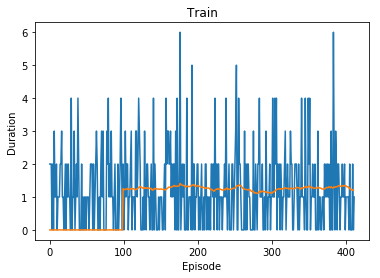

In [11]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

policy_net.train().to(device)
target_net.eval().to(device)

state_holder = StateHolder()
test_rewards = []

# Общее число 
steps_done = 0

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm(range(NUM_EPISODES)):
    
    # Инициализации разлинычх переменных
    # env - среды
    # state_holder - хранителя состояния
    # lives - количества жизней в начале эпизода игры (Важно!)
    
    env.reset()
    state_holder.reset()
    lives = 5
    ep_rewards = []
    
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1                                        # возможно стоит сбрасывать steps_done
        
        # Шаг одного кадра игры 
        
        
        state = state_holder.get().to(device)
        action = select_action (state, eps_threshold)
        
        _, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        
        ep_rewards.append (reward)
        
        state_holder.push (get_screen ())
        if not done:
            next_state = state_holder.get()
        else:
            next_state = None
        
        
        # Код обработки перехода
        # Работа с ReplayMemory
        
        memory.push (state, action, next_state, reward)
        
        # Задание 3.1. Необходимо дополнить код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тем самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        if (info['ale.lives'] < lives):
            memory.push (state, action, 0, reward)
            lives -= lives
        
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
            
            plot_rewards()
            break 
    
    if (e % 100 == 0):
        saveToFile (policy_net, "policyNet1.pkl")
        saveToFile (target_net, "targetNet1.pkl")
        saveToFile (memory    , "memory.pkl")
        saveToFile (env       , "environment.pkl")



In [ ]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))